# Data Science Challenge for Idoven

In [1]:
# Import useful libraries and annotation data

from matplotlib import pyplot as plt 
import numpy as np
import pandas as pd
import os
import seaborn as sns
import wfdb

from utils.plot_ecg import _set_clean_axis, plot_ecg, plot_ecg_complete


DATA_PATH = os.path.join(os.getcwd(), 'data', 'ptb-xl')

database = pd.read_csv(os.path.join(DATA_PATH, 'ptbxl_database.csv'), index_col = 0)
statements = pd.read_csv(os.path.join(DATA_PATH, 'scp_statements.csv'), index_col = 0)

## Read the ECG files and plot the signal

In [21]:
# Load one example ECG data at 100Hz, randomly chosen

rec = np.random.choice(database['filename_lr'])
rec = 'records100/04000/04880_lr'
print('reading', rec)
x = wfdb.rdsamp(os.path.join(DATA_PATH, rec))
x = np.array(x[0])
print('ECG data shape:', x.shape)

reading records100/04000/04880_lr
ECG data shape: (1000, 12)


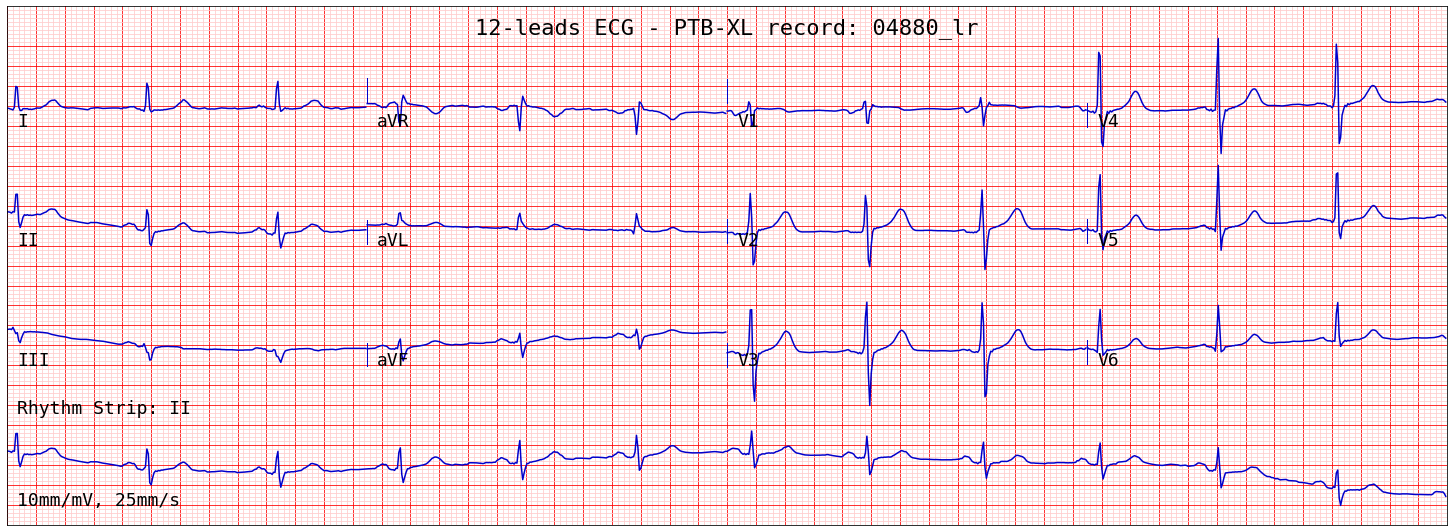

In [22]:
# Plot ECG with classical 12-leads presentation

_set_clean_axis() 
plot_ecg(x, rec, display_factor = 2)

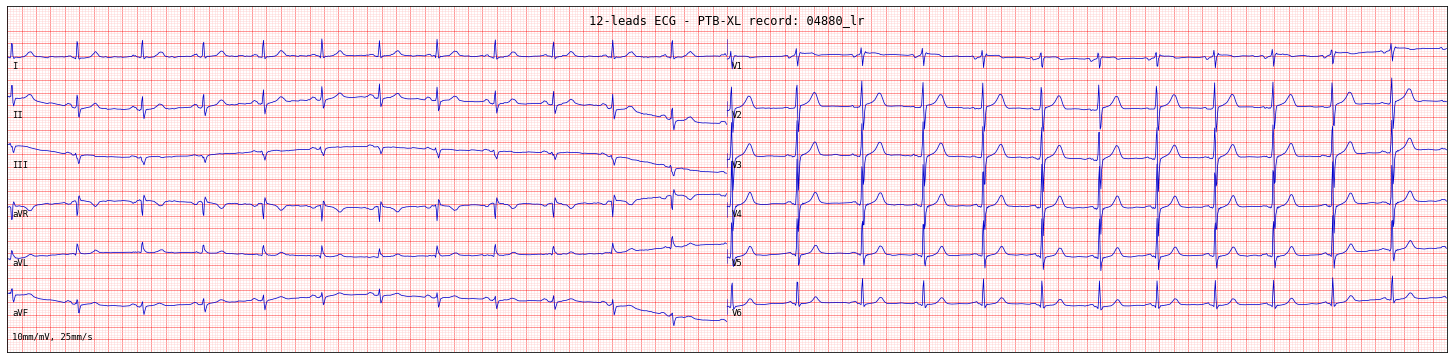

In [23]:
# Show all 12 complete leads, instead of 2.5 secs per lead

plot_ecg_complete(x, rec)

In [27]:
# Read the annotation data for this example

info = database.loc[int(rec.split('/')[-1].split('_')[0])]

print('Participant ID:\t',info.patient_id)
print('Age:\t',info.age)
print('Sex:\t','Male' if info.sex == 1 else 'Female')
print('Record date:\t',info.recording_date)
print('Report by doctor:\t',info.report)

if not pd.isna(info.baseline_drift):
    print('Baseline Drift in lead(s):', info.baseline_drift)
if not pd.isna(info.static_noise):
    print('Static Noise in lead(s):', info.baseline_drift)
if not pd.isna(info.burst_noise):
    print('Burst Noise in lead(s):', info.baseline_drift)
if not pd.isna(info.electrodes_problems):
    print('Electrodes problems in lead(s):', info.baseline_drift)

if not pd.isna(info.extra_beats):
    print('Extra beats:', info.extra_beats)
if not pd.isna(info.pacemaker):
    print('Pacemaker:', info.pacemaker)


Participant ID:	 16127.0
Age:	 57.0
Sex:	 Female
Record date:	 1990-09-04 08:50:01
Report by doctor:	 sinusrhythmus linkstyp sonst normales ekg
Baseline Drift in lead(s):  , III


## Identify the heartbeat of the signal, average and total heartrate in the signal

In [4]:
# BEAT DETECTION -- in order to have engzee_detector work, ecg sampled at 500Hz should be used (the function has a built-in bandstop filter at 50Hz, which requires signals sampled at > 100Hz)

from utils.beat_detectors import *

# Select ECG signal to be processed

rec = np.random.choice(database['filename_hr'])
# Cases Tested:
rec = np.random.choice([
    'records500/07000/07841_hr',
    'records500/16000/16489_hr', 
    'records500/15000/15857_hr', # bad example
    'records500/20000/20015_hr' # bad example
])
rec = 'records500/15000/15857_hr'
print('reading', rec)
x = np.array(wfdb.rdsamp(os.path.join(DATA_PATH, rec))[0])
print('ECG data shape:', x.shape)


reading records500/15000/15857_hr
ECG data shape: (5000, 12)


### ecg_detectors + post processing

In [11]:
# Compute QRS detection - using all the available methods & compute QRS detection in all 12 channels

'''
Input arguments:

- ecg: input signal, matrix (M, N) with M = number of samples, N = number of channels (leads). The raw signal can be feed into this function, as the detectors already have a built-in method for filtering

- record_name: from database['filename_lr'] or database['filename_hr']. Needed to retrieve the ecg_id (title for plotting) and sampling frequency

- leads: string or list with the name of the channel(s) on which the detection will be performed
  Channels can be choosen among: ['I', 'II', 'III', 'aVR', 'aVL', 'aVF', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6']
  To run all of them, just set: leads='all' (default)

- methods: string or list of methods that can be choosen to run the detcetion
  Methods to be choose among: ['Elgendi et al (Two average)', 'Kalidas & Tamil (Wavelet transform)', 'Engzee', 'Christov', 'Hamilton', 'Pan Tompkins', 'WQRS']
  To run all of them, set: methods='all' (default)
'''

# res = detect_Rpeaks(x, record_name = rec, methods='Kalidas & Tamil (Wavelet transform)')
res = detect_Rpeaks(x, record_name = rec, methods='all')
pd.DataFrame(res)

,I,II,III,aVR,aVL,aVF,V1,V2,V3,V4,V5,V6
Elgendi et al (Two average),"[312, 739, 1164, 1591, 2000, 2426, 2870, 3361,...","[364, 791, 1215, 1640, 2068, 2495, 2920, 3345,...","[364, 791, 1214, 1639, 2068, 2495, 2919, 3344,...","[339, 766, 1190, 1615, 2043, 2470, 2895, 3320,...","[381, 809, 1233, 1657, 2086, 2513, 2937, 3363,...","[106, 364, 791, 1215, 1640, 2068, 2495, 2920, ...","[334, 761, 1186, 1610, 2039, 2465, 2891, 3315,...","[336, 763, 1188, 1612, 2041, 2467, 2893, 3317,...","[333, 762, 1202, 1628, 2038, 2465, 2906, 3332,...","[328, 782, 1207, 1633, 2062, 2487, 2912, 3338,...","[367, 794, 1220, 1644, 2071, 2499, 2924, 3348,...","[367, 794, 1219, 1643, 2071, 2498, 2923, 3348,..."
Kalidas & Tamil (Wavelet transform),"[154, 306, 635, 1138, 1575, 1924, 2410, 2835, ...","[155, 307, 704, 1135, 1578, 1970, 2420, 2840, ...","[152, 306, 692, 1125, 1551, 1982, 2403, 2835, ...","[155, 306, 691, 1137, 1615, 1983, 2410, 2864, ...","[152, 306, 602, 757, 1138, 1590, 1924, 2402, 2...","[156, 322, 697, 1138, 1563, 1982, 2408, 2843, ...","[161, 319, 739, 1140, 1583, 1975, 2409, 2845, ...","[155, 309, 734, 1166, 1587, 1993, 2465, 2865, ...","[156, 313, 712, 1131, 1557, 2038, 2446, 2899, ...","[151, 334, 724, 1135, 1565, 1984, 2410, 2865, ...","[153, 320, 704, 1149, 1563, 1983, 2409, 2895, ...","[152, 306, 713, 1150, 1565, 1990, 2431, 3249, ..."
Engzee,[3734],NaN,[],[1557],"[1185, 1611, 3745, 4170, 4594]",[],NaN,"[700, 1553, 2405, 3258]",[242],[3258],[],NaN
Christov,"[282, 742, 1166, 1592, 2021, 2448, 2866, 3264,...","[243, 344, 769, 1195, 1617, 2046, 2475, 2881, ...","[274, 375, 797, 1170, 1596, 2024, 2500, 2849, ...","[288, 744, 1168, 1593, 2024, 2450, 2868, 3264,...","[279, 742, 1166, 1592, 2020, 2447, 2847, 3264,...","[242, 343, 771, 1196, 1619, 2049, 2477, 2848, ...","[287, 739, 1163, 1589, 2017, 2443, 2863, 3288,...","[275, 741, 1165, 1590, 2018, 2444, 2862, 3284,...","[271, 743, 1170, 1594, 2021, 2446, 2861, 3267,...","[242, 344, 709, 1137, 1563, 2018, 2445, 2846, ...","[274, 746, 1170, 1596, 2026, 2453, 2870, 3294,...","[276, 746, 1171, 1597, 2026, 2453, 2871, 3295,..."
Hamilton,"[168, 336, 740, 1166, 1592, 2000, 2441, 2870, ...","[171, 340, 719, 1145, 1579, 2009, 2438, 2869, ...","[165, 325, 706, 1161, 1590, 1983, 2441, 2842, ...","[159, 312, 716, 947, 1137, 1564, 1997, 2423, 2...","[161, 315, 707, 1164, 1589, 2015, 2441, 2841, ...","[170, 322, 705, 1158, 1557, 1986, 2414, 2844, ...","[222, 383, 738, 1164, 1615, 2015, 2443, 2868, ...","[215, 387, 725, 1164, 1575, 2016, 2443, 2870, ...","[232, 607, 774, 1149, 1574, 2007, 2429, 2869, ...","[186, 338, 724, 1149, 1590, 2010, 2441, 2869, ...","[163, 340, 738, 1164, 1571, 1998, 2422, 2869, ...","[254, 725, 1164, 1572, 2016, 2423, 2869, 3276,..."
Pan Tompkins,"[153, 349, 709, 1136, 1629, 2051, 2448, 2875, ...","[174, 346, 719, 1155, 1623, 1995, 2419, 2831, ...","[156, 312, 700, 1199, 1553, 1985, 2411, 2831, ...","[175, 347, 709, 1138, 1565, 2000, 2451, 2876, ...","[156, 315, 708, 1168, 1626, 1982, 2478, 2842, ...","[166, 324, 706, 1161, 1586, 2015, 2415, 2831, ...","[235, 389, 773, 1199, 1626, 2018, 2444, 2904, ...","[157, 347, 701, 1199, 1625, 2022, 2478, 2874, ...","[161, 347, 773, 1169, 1593, 2022, 2478, 2905, ...","[166, 326, 753, 1176, 1614, 1982, 2407, 2905, ...","[177, 347, 748, 1199, 1625, 1999, 2424, 2904, ...","[177, 347, 748, 1148, 1625, 1999, 2424, 2878, ..."
WQRS,"[14, 287, 734, 1159, 1587, 1989, 2429, 2866, 3...","[2, 276, 742, 952, 1169, 1592, 1995, 2425, 266...","[66, 279, 711, 1143, 1579, 1992, 2433, 2846, 3...","[5, 287, 738, 934, 1163, 1589, 1993, 2424, 267...","[32, 283, 716, 1154, 1583, 1989, 2431, 2859, 3...","[4, 276, 709, 1151, 1577, 2008, 2436, 2845, 32...","[24, 298, 734, 1160, 1586, 2013, 2439, 2865, 3...","[5, 283, 730, 1157, 1583, 2010, 2438, 2866, 32...","[9, 277, 718, 1149, 1576, 2003, 2433, 2865, 32...","[35, 275, 706, 1141, 1568, 1999, 2434, 2862, 3...","[39, 278, 736, 1164, 1589, 2017, 2445, 2639, 2...","[24, 281, 738, 1163, 1590, 2018, 2444, 2669, 2..."


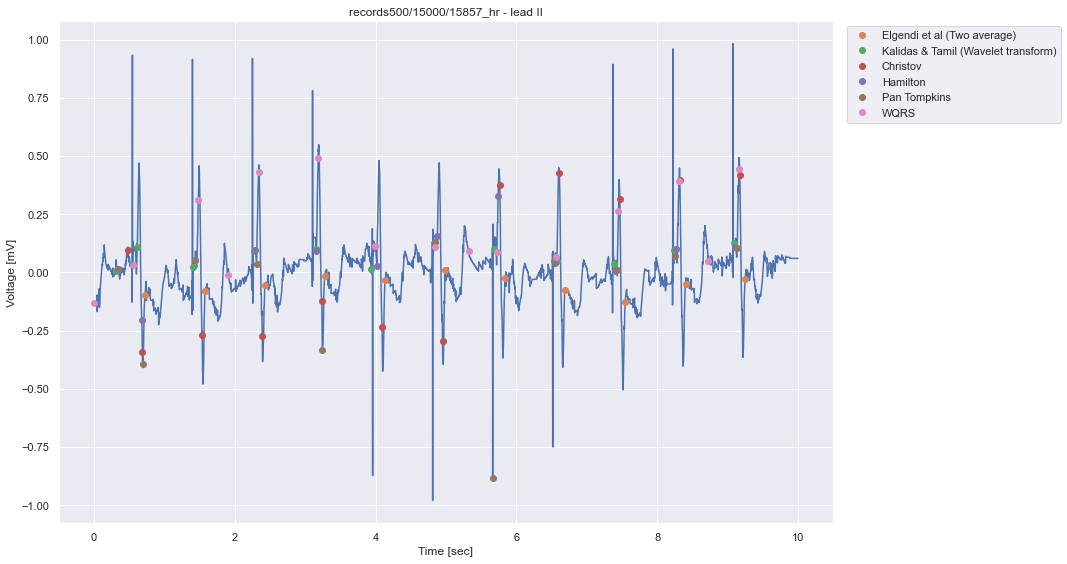

In [12]:
# Plot the unfiltered signal with the reuslts of the different detectors on lead II. 

plot_annotations(x, {'II': res['II']}, rec)

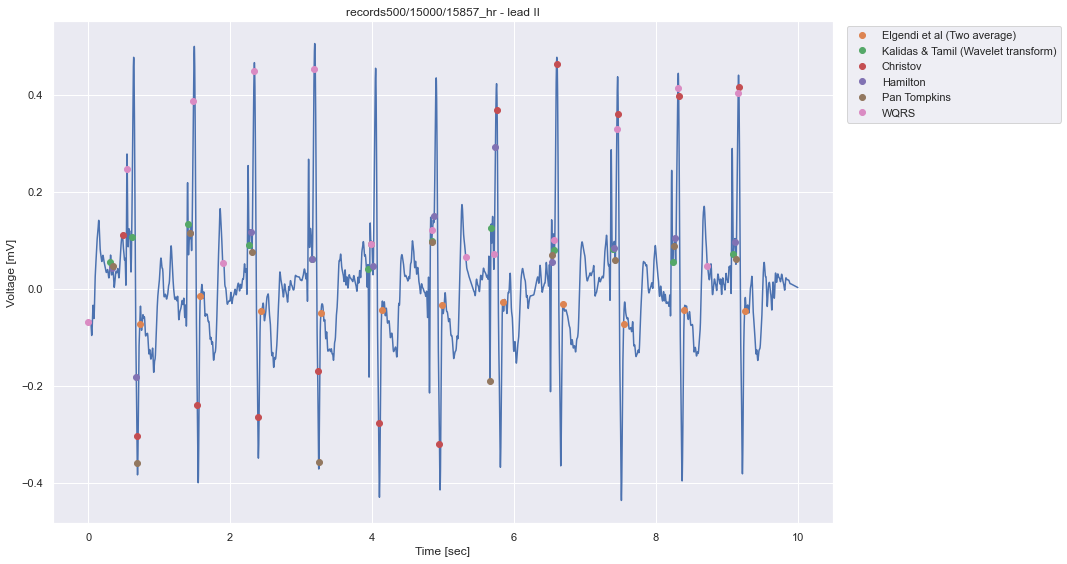

In [13]:
# Plot the filtered signal with the reuslts of the different detectors on lead II. 

from utils.filters import filter_bandpass


x_filt = filter_bandpass(x)
plot_annotations(x_filt, {'II': res['II']}, rec)

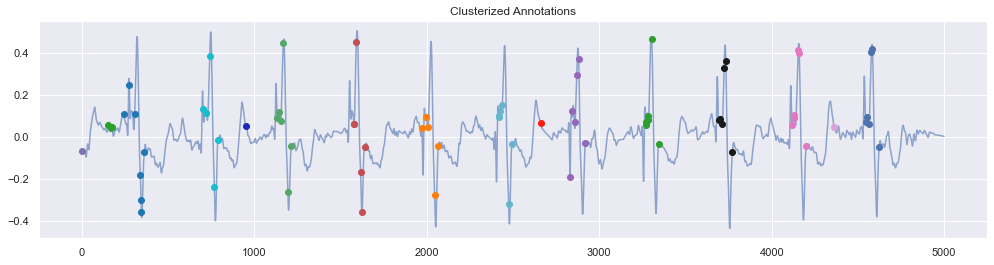

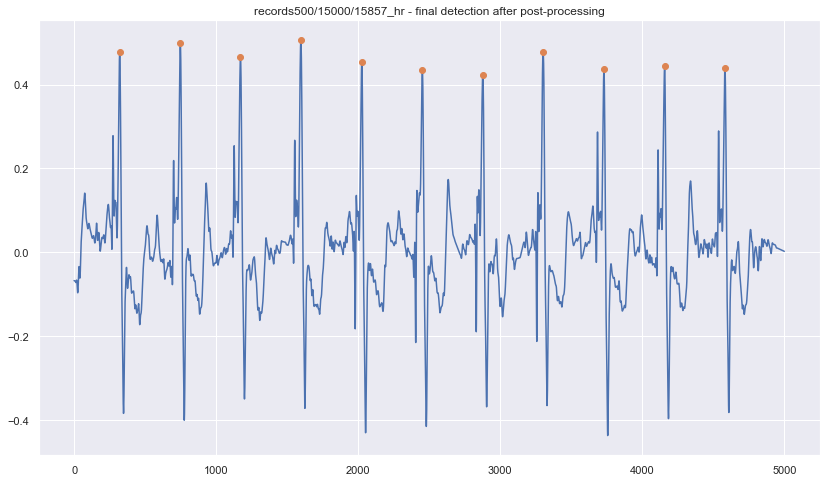

In [9]:
# Merge multiple detectors - Agglomerative cluster is performed, to group all the annotations from the different detectors that are referred to the same beat

import warnings


warnings.filterwarnings('ignore')

merge_multiple_detections_on_single_channel(x_filt, res, rec, channel = 'II')

### Neurokit

In [14]:
import neurokit2 as nk
import warnings
warnings.filterwarnings('ignore')

signals, info = nk.ecg_process(x[:, 0], sampling_rate=500)

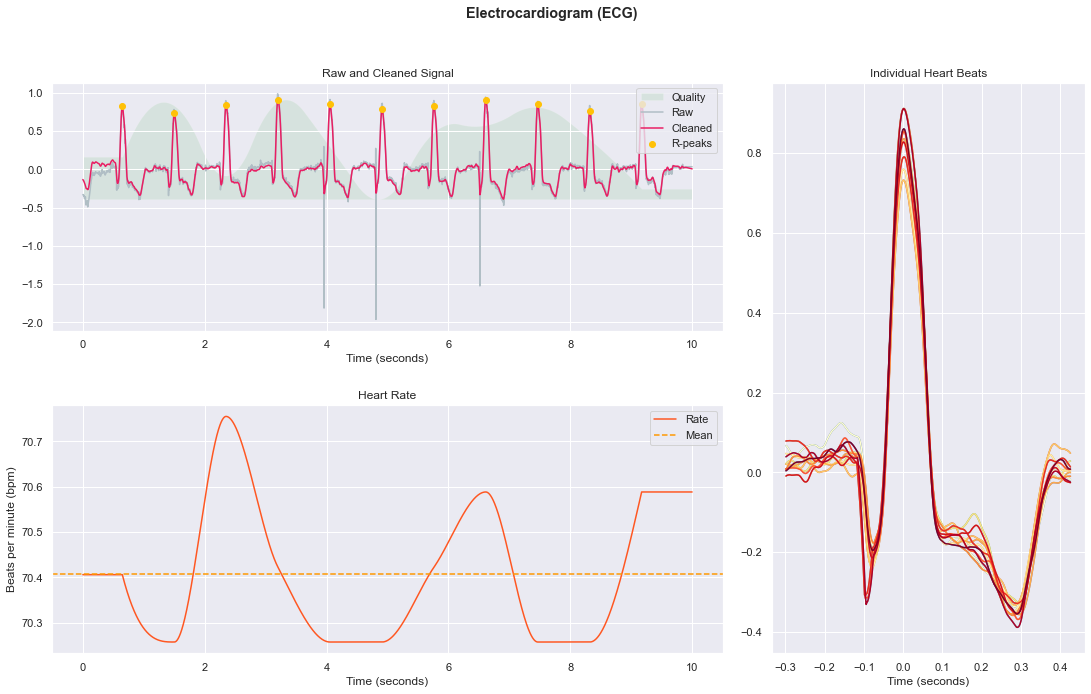

In [15]:
warnings.filterwarnings('ignore')
fig = nk.ecg_plot(signals, sampling_rate=500, show_type="default")
fig.set_size_inches(18.5, 10.5, forward=True)
plt.show()


### wfdb

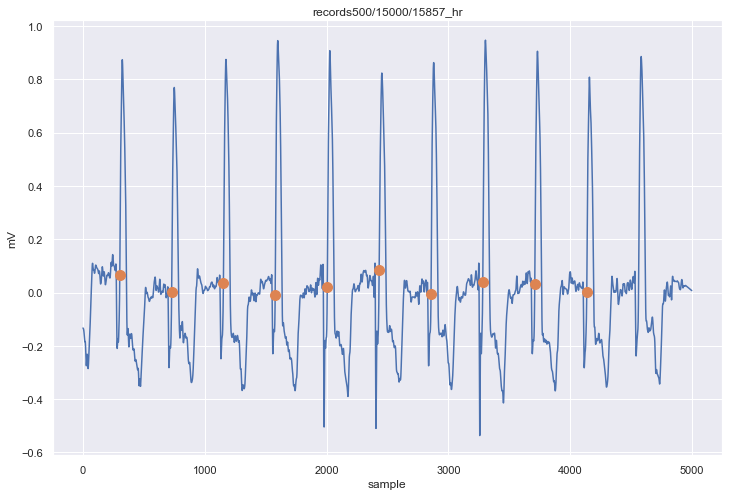

In [20]:
# GQRS detector

from wfdb import processing

qrs_pos = processing.gqrs_detect(x_filt[:, 0], fs = 500)
plt.figure(figsize = (12, 8)),
plt.plot(x_filt[:, 0]), plt.title(rec), plt.xlabel('sample'), plt.ylabel('mV')
plt.plot(qrs_pos, x_filt[qrs_pos,0], 'o', markersize = 10);

Learning initial signal parameters...
Failed to find 8 beats during learning.
Initializing using default parameters
Running QRS detection...
QRS detection complete.


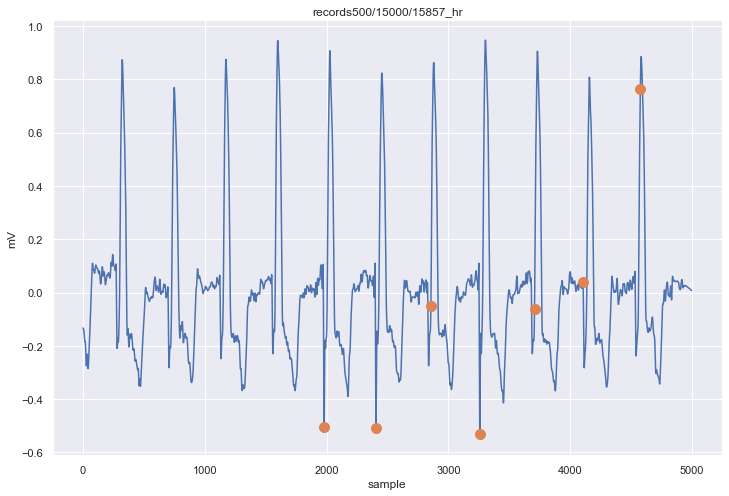

In [21]:
# GQRS detector

qrs_pos = processing.xqrs_detect(x_filt[:, 0], fs = 500)
plt.figure(figsize = (12, 8)),
plt.plot(x_filt[:, 0]), plt.title(rec), plt.xlabel('sample'), plt.ylabel('mV')
plt.plot(qrs_pos, x_filt[qrs_pos,0], 'o', markersize = 10);

#### Detect number of beats, compute mean HeartRate - using neurokit2

In [22]:
hr_from_nbeats = len(info['ECG_R_Peaks']) * 6
print('heart rate for record', rec, 'is', hr_from_nbeats, 'bpm (beats per minute)')


heart rate for record records500/15000/15857_hr is 66 bpm (beats per minute)


In [19]:
# Mean HR from RR interval

60 / np.mean(wfdb.processing.calc_rr(qrs_pos, fs=500, rr_units = 'seconds'))

94.23378954453668

In [20]:
# Mean HR from instantaneus HR calculation with wfdb library

hr = processing.compute_hr(5000, qrs_pos, fs=500)
np.mean(hr[~np.isnan(hr)])


100.48973

## ECG Delineation

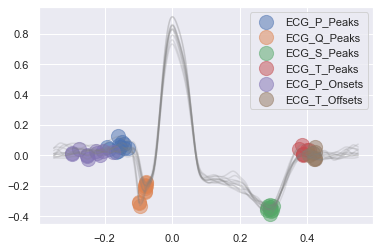

In [71]:
signals, info = nk.ecg_process(x[:, 0], sampling_rate=500)
delineation, waves_peak = nk.ecg_delineate(signals['ECG_Clean'], signals[signals.ECG_R_Peaks == 1].index, sampling_rate=500, method="peak", show=True, show_type='all')